In [26]:
import gradient_descent as gd

import autograd.numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
from autograd import grad

In [27]:
# Data
n = 100
x = 2*np.linspace(-1,1,n)
y = 1 + 2*x + 3*x**2# + np.random.randn(n)

# Second degree Vandermonde matrix
p = 2
X = np.c_[*(x**i for i in range(p+1))]

# OLS

In [28]:
# OLS
OLS_grad = (gd.MSE_OLS, [])

# analytical solution for comparisons
XTX = X.T @ X
beta = np.linalg.inv(XTX) @ X.T @ y
H = 2/n * XTX
EigVal, EigVec = np.linalg.eig(H) # we will cheat to find upper bound on learning rate
upper_bound_learning_rate = 1/np.max(EigVal) # note: H positive definite = positive eigenvalues
print(f"The analytical learning rate is about {upper_bound_learning_rate:.5f}")

The analytical learning rate is about 0.12639


In [29]:
# Analysing the convergence as a function of learnign rate for
# plainGD, MomentumGD, StochasticGD, AdaGrad, RMSprop and ADAM with Goodfellow/Bengio-recommended other varaibles

from gradient_descent import GradientDescent, AdaGradGD, RMSPropGD, ADAMGD

learning_rates = upper_bound_learning_rate*np.array([.001,.01,.1,1])
special_learning_rates = np.array([.001,.01,.1, 1, 10, 100, 1_000, 10_000])

max_iter = epochs = 10_000
def time_fit(method, test=True):
    start = timer()
    theta, iters = method.fit(X,y)
    end = timer()
    time = end - start

    if iters < max_iter and test:
        msg = f"Bad convergence: {beta} {theta} and {iters} {method})"
        assert np.allclose(theta, beta, 1e-1), msg
    
    return theta, iters, time


def test_criterion(self, tol, beta=beta):
    return not np.allclose(self.theta, beta, tol)

# Tracking iterations/epochs and time
k = len(learning_rates)
kk = len(special_learning_rates)
plain_iters, plain_times = np.zeros(k), np.zeros(k)
mom_iters,   mom_times   = np.zeros(k), np.zeros(k)
sgd_epochs,  sgd_times   = np.zeros(k), np.zeros(k)
msgd_epochs, msgd_times  = np.zeros(k), np.zeros(k)
adg_epochs,  adg_times   = np.zeros(kk), np.zeros(kk)
rms_epochs,  rms_times   = np.zeros(kk), np.zeros(kk)
adam_epochs, adam_times  = np.zeros(kk), np.zeros(kk)

for i, learning_rate in enumerate(learning_rates):
    # Non-stochastic methods
    PlainGD    = GradientDescent(learning_rate, max_iter, tol=.1, momentum=0,  cost_gradient=OLS_grad, criterion=test_criterion) 
    MomentumGD = GradientDescent(learning_rate, max_iter, tol=.1, momentum=.5, cost_gradient=OLS_grad, criterion=test_criterion)
    theta, plain_iters[i], plain_times[i] = time_fit(PlainGD)
    theta, mom_iters[i],   mom_times[i]   = time_fit(MomentumGD)
    # Stochastic methods (might require lower tolerance than plainGD, so the comparison is bad without using test_criterion!)
    MomentumSGD   = GradientDescent(learning_rate, epochs, tol=.1, momentum=.5, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    StochastichGD = GradientDescent(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    theta, sgd_epochs[i],  sgd_times[i]   = time_fit(StochastichGD)
    theta, msgd_epochs[i], msgd_times[i]  = time_fit(MomentumSGD)

for i, learning_rate in enumerate(special_learning_rates):
    # These models tolerate higher learning rates than the analytical bound. We use Goodfellow/Bengio's recommendations for the unspecified variables.
    AdaGrad = AdaGradGD(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    RMSProp = RMSPropGD(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    ADAM    = ADAMGD(   learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    theta, adg_epochs[i],  adg_times[i]   = time_fit(AdaGrad)
    theta, rms_epochs[i],  rms_times[i]   = time_fit(RMSProp)
    theta, adam_epochs[i], adam_times[i]  = time_fit(ADAM)

[10000.  1614.   111.    11.] [5509.  360.   33.    8.]


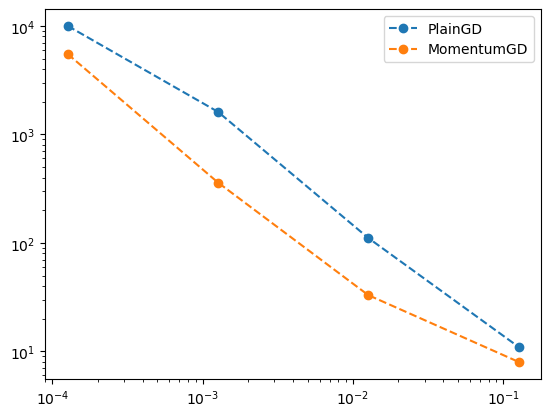

[1.224e+03 1.370e+02 1.300e+01 1.000e+00] [504.  86.  11.   3.]


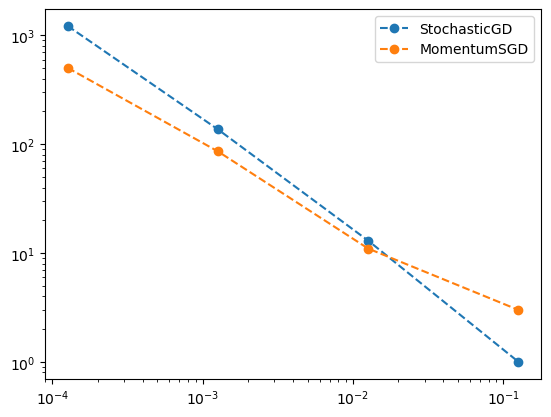

[1.00e+04 1.00e+04 5.24e+02 9.00e+00 2.00e+00 3.00e+00 4.00e+00 4.00e+00] [ 551.   59.    9.    2.    2.    3. 1114.    3.] [1078.  210.   22.    9.   16.   45.   50.   52.]


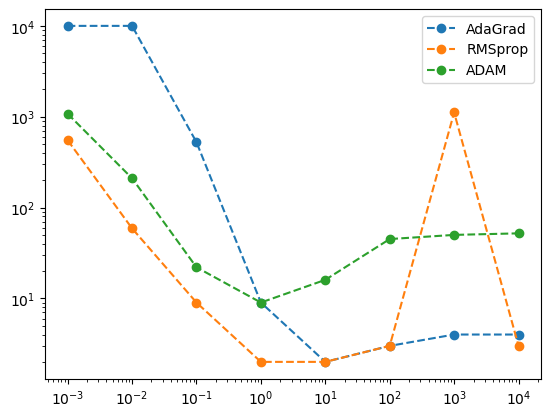

In [30]:
print(plain_iters, mom_iters)
# loglog of iterations against learning rates
plt.loglog(learning_rates, plain_iters, "o--", label="PlainGD")
plt.loglog(learning_rates, mom_iters, "o--", label="MomentumGD")
plt.legend()
plt.show()

# ... epochs against learning rates (clearly, Adagrad and Rmsprop are wrong; the change becomes way to small way to fast. Could be to small batches? Either way, rms is ok with test_criterion. adg is just very broken!)
print(sgd_epochs, msgd_epochs)
plt.loglog(learning_rates, sgd_epochs, "o--", label="StochasticGD")
plt.loglog(learning_rates, msgd_epochs, "o--", label="MomentumSGD")
plt.legend()
plt.show()

print(adg_epochs, rms_epochs, adam_epochs)
plt.loglog(special_learning_rates, adg_epochs, "o--", label="AdaGrad")
plt.loglog(special_learning_rates, rms_epochs, "o--", label="RMSprop")
plt.loglog(special_learning_rates, adam_epochs, "o--", label="ADAM")
plt.legend()
plt.show()

1.02, 0.76, 0.39, 1.81, 1.19, 1.13, 10.13 ms
11.0 8.0 1.0 3.0 2.0 2.0 9.0
0.1263873114780182 0.1263873114780182 0.1263873114780182 0.1263873114780182 10.0 10.0 1.0


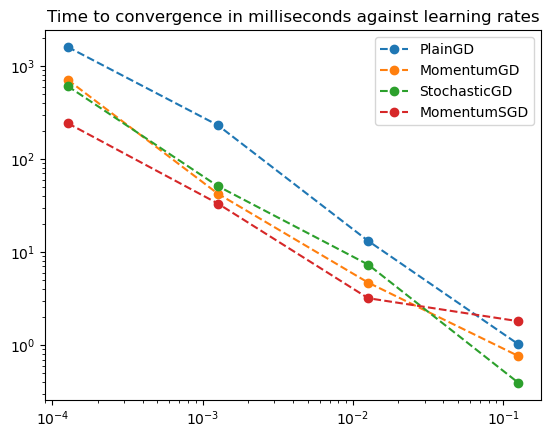

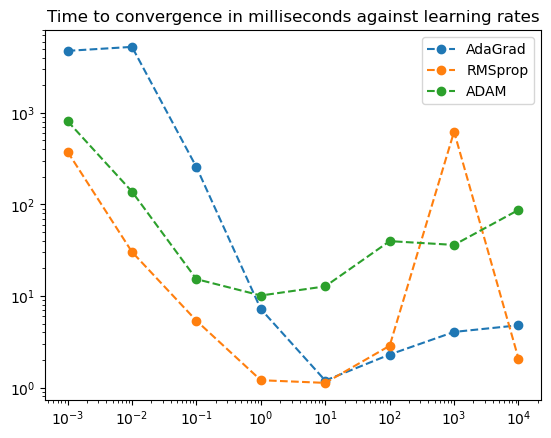

In [31]:
# Time to convergence comparison.
plain, mom, sgd, msgd, adg, rms, adam = np.argmin(plain_times), np.argmin(mom_times), np.argmin(sgd_times), np.argmin(msgd_times), np.argmin(adg_times), np.argmin(rms_times), np.argmin(adam_times)
best_times = f"{plain_times[plain]*1e3:.2f}, {mom_times[mom]*1e3:.2f}, {sgd_times[sgd]*1e3:.2f}, {msgd_times[msgd]*1e3:.2f}, {adg_times[adg]*1e3:.2f}, {rms_times[rms]*1e3:.2f}, {adam_times[adam]*1e3:.2f}"
best_iters = plain_iters[plain], mom_iters[mom], sgd_epochs[sgd], msgd_epochs[msgd], adg_epochs[adg], rms_epochs[rms], adam_epochs[adam]
best_rates = learning_rates[plain], learning_rates[mom], learning_rates[sgd], learning_rates[msgd], special_learning_rates[adg], special_learning_rates[rms], special_learning_rates[adam]
print(best_times, 'ms')
print(*best_iters)
print(*best_rates)

# Plots
plt.loglog(learning_rates, plain_times*1e3, "o--", label="PlainGD")
plt.loglog(learning_rates, mom_times*1e3,   "o--", label="MomentumGD")
plt.loglog(learning_rates, sgd_times*1e3,   "o--", label="StochasticGD")
plt.loglog(learning_rates, msgd_times*1e3,  "o--", label="MomentumSGD")
plt.title("Time to convergence in milliseconds against learning rates")
plt.legend()
plt.show()

plt.loglog(special_learning_rates, adg_times*1e3,  "o--", label="AdaGrad")
plt.loglog(special_learning_rates, rms_times*1e3,  "o--", label="RMSprop")
plt.loglog(special_learning_rates, adam_times*1e3, "o--", label="ADAM")
plt.title("Time to convergence in milliseconds against learning rates")
plt.legend()
plt.show()

## Hva ser vi?
Jo, ADAM er mest stabil og funker fint nesten uansett. RMS-prop er veldig ustabil, men er svært rask når epsilon er helt riktig. AdaGrad trenger veldig store epsilon for å funke (når ikke engang konvergens for "vanlige" verdier) men er aller best for høye epsilon (trenger kun én epoke!). Merk at dette er for en ekstremt enkel funksjon, så kompliserte modeller blir ikke verdsatt slik de bør.

Er noe kanksje galt når adagrad funker best med alla epsilon = 1e6? Ja... men det funker.

# Ridge

Analyze the convergence as a function of $\eta$ for OLS (DONE) and Ridge (CURRENTLY), for Ridge also look at $\lambda$ (Heatmap!).
 - add custom stopping crit to ensure minimal number of iters for all methods. Note that sgd-methods may "overshoot" a bit since we only test each epoch. DONE

- *plot MSE as a function of learning rate for the different methods*. Look at MSE as function of number of epochs, size of batches.  LESS RELEVANT WITH SIMPLE FUNCTION; WILL DO LATER if FRANKE

Use analytical gradient, then replace with autograd/JAX.  
Compare results with those from scikitlearns SGD options.

In [1]:
import gc # in case memory is filled by old class instances? 
for obj in gc.get_objects():
    if isinstance(obj, GradientDescent):
        del obj
gc.collect()

NameError: name 'GradientDescent' is not defined

In [20]:
# Ridge - same data as ols
llambdas = [.001, .1, 10] # logspace 100
special_learning_rates = np.array([.001,.01,.1, 1, 10, 100, 1_000, 10_000]) # do logspace ofc

# Tracking iterations/epochs and time
k = len(learning_rates)
kk = len(special_learning_rates)
kkk = len(llambdas)
plain_iters, plain_times = np.zeros((k,kkk)), np.zeros((k,kkk))
mom_iters,   mom_times   = np.zeros((k,kkk)), np.zeros((k,kkk))
sgd_epochs,  sgd_times   = np.zeros((k,kkk)), np.zeros((k,kkk))
msgd_epochs, msgd_times  = np.zeros((k,kkk)), np.zeros((k,kkk))
adg_epochs,  adg_times   = np.zeros((kk,kkk)), np.zeros((kk,kkk))
rms_epochs,  rms_times   = np.zeros((kk,kkk)), np.zeros((kk,kkk))
adam_epochs, adam_times  = np.zeros((kk,kkk)), np.zeros((kk,kkk))

I = np.eye(p+1)
XTX = X.T @ X
for j, llambda in enumerate(llambdas):
    ridge_grad = (gd.MSE_Ridge, [llambda])
    beta = np.linalg.inv(XTX + n*llambda*I) @ X.T @ y # analytical solution, including the scaling factor (n)
    
    def test_criterion(self, tol, beta=beta):
        return not np.allclose(self.theta, beta, tol)

    # Finding optimal step for the simple models
    H = 1/n*XTX + llambda*I
    EigVal, EigVec = np.linalg.eig(H)
    upper_bound_learning_rate = 1/np.max(EigVal)
    learning_rates = upper_bound_learning_rate*np.array([.001,.01,.1,1]) # logspace

    for i, learning_rate in enumerate(learning_rates):
        # Non-stochastic methods
        PlainGD       = GradientDescent(learning_rate, max_iter, tol=.1, momentum=0,  cost_gradient=ridge_grad, criterion=test_criterion) 
        MomentumGD    = GradientDescent(learning_rate, max_iter, tol=.1, momentum=.5, cost_gradient=ridge_grad, criterion=test_criterion)
        theta, plain_iters[i,j], plain_times[i,j] = time_fit(PlainGD)
        theta, mom_iters[i,j],   mom_times[i,j]   = time_fit(MomentumGD)
        # Stochastic methods (lower tolerance due required)
        MomentumSGD   = GradientDescent(learning_rate, epochs, tol=.1, momentum=.5, cost_gradient=ridge_grad, batch_size=16, criterion=test_criterion)
        StochastichGD = GradientDescent(learning_rate, epochs, tol=.1, cost_gradient=ridge_grad, batch_size=16, criterion=test_criterion)
        theta, sgd_epochs[i,j],  sgd_times[i,j]   = time_fit(StochastichGD)
        theta, msgd_epochs[i,j], msgd_times[i,j]  = time_fit(MomentumSGD)


    for i, learning_rate in enumerate(special_learning_rates):
        AdaGrad       = AdaGradGD(learning_rate, epochs, tol=.1, cost_gradient=ridge_grad, batch_size=16, criterion=test_criterion) # Don't ask about the factor of 1000, just admire the incredible results.
        RMSProp       = RMSPropGD(learning_rate, epochs, tol=.1, cost_gradient=ridge_grad, batch_size=16, criterion=test_criterion)
        ADAM          = ADAMGD(   learning_rate, epochs, tol=.1, cost_gradient=ridge_grad, batch_size=16, criterion=test_criterion)

        theta, adg_epochs[i,j],  adg_times[i,j]   = time_fit(AdaGrad)
        theta, rms_epochs[i,j],  rms_times[i,j]   = time_fit(RMSProp)
        theta, adam_epochs[i,j], adam_times[i,j]  = time_fit(ADAM)

    print(f"Lambda = {llambda}:")
    print(f"Analytical parameters: {beta}")

Lambda = 0.001:
Analytical parameters: [1.00050511 1.99853078 2.99889315]
Lambda = 0.1:
Analytical parameters: [1.03383818 1.86303897 2.89912145]
Lambda = 10:
Analytical parameters: [0.36115077 0.23947836 0.81465456]


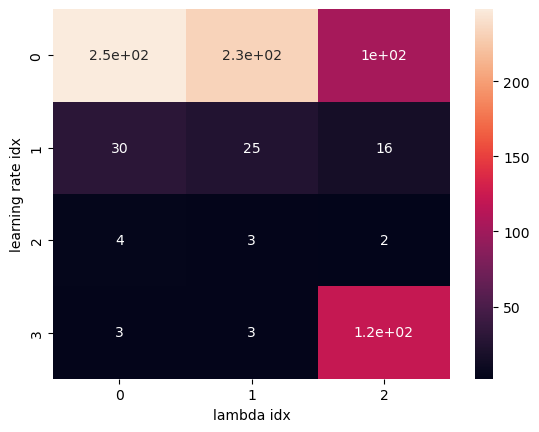

In [21]:
# we should make a map similar to what Maria made for the nn-models with multiple heatmaps

sns.heatmap(msgd_epochs, annot=True)
plt.xlabel("lambda idx")
plt.ylabel("learning rate idx")
plt.show()

## Autograd

In [22]:
import gc
for obj in gc.get_objects():
    if isinstance(obj, GradientDescent):
        del obj
gc.collect()

5013

In [23]:
def ols_cost(X, y, theta):
    return 1/len(y) * np.dot((y - np.dot(X, theta)).T, (y - np.dot(X, theta)))
OLS_grad = (grad(ols_cost, 2), []) # derivative wrt theta

def ridge_cost(X, y, theta, llambda):
    return 1/len(y) * X.T @ (X @ (theta) - y) + llambda*theta

# ridge_grad = (grad(Ridge_cost, 2), [lmb]) # derivative wrt theta
# now run exactly the same code as above again...

In [24]:
# Running the OLS code again with autograd gradient instead of analytical
# analytical solution for comparisons
XTX = X.T @ X
beta = np.linalg.inv(XTX) @ X.T @ y
H = 2/n * XTX
EigVal, EigVec = np.linalg.eig(H) # we will cheat to find upper bound on learning rate
upper_bound_learning_rate = 1/np.max(EigVal) # note: H positive definite = positive eigenvalues
print(f"The analytical learning rate is about {upper_bound_learning_rate:.5f}")

learning_rates = upper_bound_learning_rate*np.array([.001,.01,.1,1])
special_learning_rates = np.array([.001,.01,.1, 1, 10, 100, 1_000, 10_000])

max_iter = epochs = 10_000
def time_fit(method, test=True):
    start = timer()
    theta, iters = method.fit(X,y)
    end = timer()
    time = end - start

    if iters < max_iter and test:
        msg = f"Bad convergence: {beta} {theta} and {iters} {method})"
        assert np.allclose(theta, beta, 1e-1), msg
    
    return theta, iters, time


def test_criterion(self, tol, beta=beta):
    return not np.allclose(self.theta, beta, tol)

# Tracking iterations/epochs and time
k = len(learning_rates)
kk = len(special_learning_rates)
plain_iters, plain_times = np.zeros(k), np.zeros(k)
mom_iters,   mom_times   = np.zeros(k), np.zeros(k)
sgd_epochs,  sgd_times   = np.zeros(k), np.zeros(k)
msgd_epochs, msgd_times  = np.zeros(k), np.zeros(k)
adg_epochs,  adg_times   = np.zeros(kk), np.zeros(kk)
rms_epochs,  rms_times   = np.zeros(kk), np.zeros(kk)
adam_epochs, adam_times  = np.zeros(kk), np.zeros(kk)

for i, learning_rate in enumerate(learning_rates):
    print(i)
    # Non-stochastic methods
    PlainGD    = GradientDescent(learning_rate, max_iter, tol=.1, momentum=0,  cost_gradient=OLS_grad, criterion=test_criterion) 
    MomentumGD = GradientDescent(learning_rate, max_iter, tol=.1, momentum=.5, cost_gradient=OLS_grad, criterion=test_criterion)
    theta, plain_iters[i], plain_times[i] = time_fit(PlainGD)
    theta, mom_iters[i],   mom_times[i]   = time_fit(MomentumGD)
    # Stochastic methods (might require lower tolerance than plainGD, so the comparison is bad without using test_criterion!)
    MomentumSGD   = GradientDescent(learning_rate, epochs, tol=.1, momentum=.5, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    StochastichGD = GradientDescent(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    theta, sgd_epochs[i],  sgd_times[i]   = time_fit(StochastichGD)
    theta, msgd_epochs[i], msgd_times[i]  = time_fit(MomentumSGD)

for i, learning_rate in enumerate(special_learning_rates):
    print(i)
    # These models tolerate higher learning rates than the analytical bound. We use Goodfellow/Bengio's recommendations for the unspecified variables.
    AdaGrad = AdaGradGD(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    RMSProp = RMSPropGD(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    ADAM    = ADAMGD(   learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    theta, adg_epochs[i],  adg_times[i]   = time_fit(AdaGrad)
    theta, rms_epochs[i],  rms_times[i]   = time_fit(RMSProp)
    theta, adam_epochs[i], adam_times[i]  = time_fit(ADAM)

The analytical learning rate is about 0.12639
0
1
2
3
0
1
2
3
4
5
6
7


6.38, 8.81, 27.36, 9.32, 13.06, 13.00, 29.99 ms
9.0 8.0 3.0 2.0 2.0 2.0 4.0
0.1263873114780182 0.1263873114780182 0.1263873114780182 0.1263873114780182 10.0 10.0 10.0


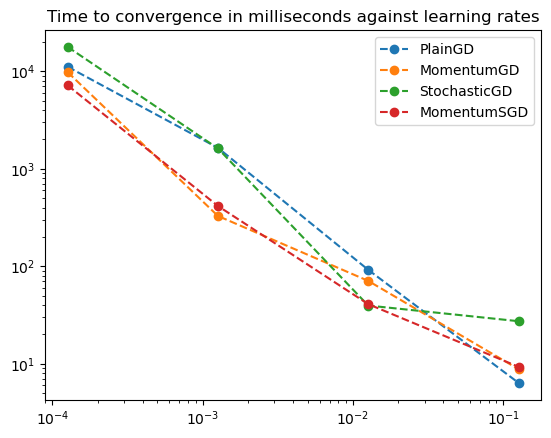

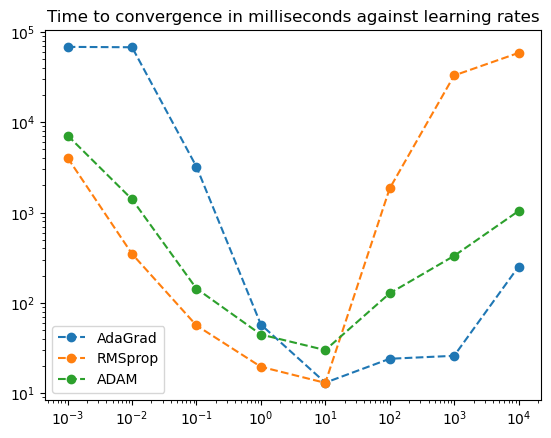

In [25]:
# Time to convergence comparison.
plain, mom, sgd, msgd, adg, rms, adam = np.argmin(plain_times), np.argmin(mom_times), np.argmin(sgd_times), np.argmin(msgd_times), np.argmin(adg_times), np.argmin(rms_times), np.argmin(adam_times)
best_times = f"{plain_times[plain]*1e3:.2f}, {mom_times[mom]*1e3:.2f}, {sgd_times[sgd]*1e3:.2f}, {msgd_times[msgd]*1e3:.2f}, {adg_times[adg]*1e3:.2f}, {rms_times[rms]*1e3:.2f}, {adam_times[adam]*1e3:.2f}"
best_iters = plain_iters[plain], mom_iters[mom], sgd_epochs[sgd], msgd_epochs[msgd], adg_epochs[adg], rms_epochs[rms], adam_epochs[adam]
best_rates = learning_rates[plain], learning_rates[mom], learning_rates[sgd], learning_rates[msgd], special_learning_rates[adg], special_learning_rates[rms], special_learning_rates[adam]
print(best_times, 'ms')
print(*best_iters)
print(*best_rates)

# Plots
plt.loglog(learning_rates, plain_times*1e3, "o--", label="PlainGD")
plt.loglog(learning_rates, mom_times*1e3,   "o--", label="MomentumGD")
plt.loglog(learning_rates, sgd_times*1e3,   "o--", label="StochasticGD")
plt.loglog(learning_rates, msgd_times*1e3,  "o--", label="MomentumSGD")
plt.title("Time to convergence in milliseconds against learning rates")
plt.legend()
plt.show()

plt.loglog(special_learning_rates, adg_times*1e3,  "o--", label="AdaGrad")
plt.loglog(special_learning_rates, rms_times*1e3,  "o--", label="RMSprop")
plt.loglog(special_learning_rates, adam_times*1e3, "o--", label="ADAM")
plt.title("Time to convergence in milliseconds against learning rates")
plt.legend()
plt.show()